-  for each line in smetana outputs, generate a triple in a consumer resource model consisting of donor organism, exchange metabolite, and recipient organism
- convert triple into reactions in antimony as save as SBML
- load SBML into MIRA
- load MIRA into pyCIEMSS (specify priors)
- simulate the model in pyCIEMSS (specify initial conditions)

### for each line in smetana outputs, generate a triple in a consumer resource model consisting of donor organism, exchange metabolite, and recipient organism

In [16]:
import pandas as pd
import tellurium as te
import antimony as at
import simplesbml 
import mira
import libsbml
import numpy as np


In [17]:
smetana_file = "../data/smetana_results/smetana_results_gurobi_victor_detailed.tsv"

smetana_df = pd.read_csv(smetana_file, sep='\t')

smetana_df

,community,medium,receiver,donor,compound,scs,mus,mps,smetana
0,all,minimal,updated_csc009,updated_csc031,M_arg__L_e,0.333333,0.08,1,0.026667
1,all,minimal,updated_csc009,updated_csc031,M_gua_e,0.333333,0.10,1,0.033333
2,all,minimal,updated_csc009,updated_csc031,M_h2s_e,0.333333,0.33,1,0.110000
3,all,minimal,updated_csc009,updated_csc031,M_hom__L_e,0.333333,0.07,1,0.023333
4,all,minimal,updated_csc009,updated_csc031,M_nh4_e,0.333333,0.09,1,0.030000
...,...,...,...,...,...,...,...,...,...
104,all,minimal,csc043,updated_csc040,M_s_e,1.000000,0.22,1,0.220000
105,all,minimal,csc043,updated_csc052,M_arg__L_e,0.333333,0.22,1,0.073333
106,all,minimal,csc043,updated_csc052,M_h2s_e,0.333333,0.78,1,0.260000
107,all,minimal,csc043,updated_csc052,M_lys__L_e,0.333333,0.46,1,0.153333


In [50]:
np.random.seed(0)

reaction_list = []
parameter_list = []
initial_values_set = set()


for index, row in smetana_df.iterrows():
    donor_reaction = f'\t{row.donor} -> {row.compound}; k_d{index}*{row.donor}'
    receiver_reaction = f'\t{row.compound} -> {row.receiver}; k_r{index}*{row.compound}'
    reaction_list.extend([donor_reaction,receiver_reaction])
    parameter_list.extend([f'\tk_d{index}={row.scs}',f'\tk_r{index}={row.mus}'])
    initial_values_set.add(row.donor)
    initial_values_set.add(row.compound)
    initial_values_set.add(row.receiver)

initial_values_string = "\n".join([f"\t{name}={np.random.uniform(0,1)}" for name in initial_values_set])
species_names_string = "\n".join([f'\t{species} is "{species}"' for species in initial_values_set])

reaction_string = "\n".join(reaction_list)
parameter_string = "\n".join(parameter_list)

antimony_file = f"""
model smetana
{reaction_string}
{parameter_string}
{initial_values_string}
{species_names_string}
end
"""

print(antimony_file)


model smetana
	updated_csc031 -> M_arg__L_e; k_d0*updated_csc031
	M_arg__L_e -> updated_csc009; k_r0*M_arg__L_e
	updated_csc031 -> M_gua_e; k_d1*updated_csc031
	M_gua_e -> updated_csc009; k_r1*M_gua_e
	updated_csc031 -> M_h2s_e; k_d2*updated_csc031
	M_h2s_e -> updated_csc009; k_r2*M_h2s_e
	updated_csc031 -> M_hom__L_e; k_d3*updated_csc031
	M_hom__L_e -> updated_csc009; k_r3*M_hom__L_e
	updated_csc031 -> M_nh4_e; k_d4*updated_csc031
	M_nh4_e -> updated_csc009; k_r4*M_nh4_e
	updated_csc031 -> M_orn_e; k_d5*updated_csc031
	M_orn_e -> updated_csc009; k_r5*M_orn_e
	updated_csc040 -> M_4abut_e; k_d6*updated_csc040
	M_4abut_e -> updated_csc009; k_r6*M_4abut_e
	updated_csc040 -> M_arg__L_e; k_d7*updated_csc040
	M_arg__L_e -> updated_csc009; k_r7*M_arg__L_e
	updated_csc040 -> M_asp__L_e; k_d8*updated_csc040
	M_asp__L_e -> updated_csc009; k_r8*M_asp__L_e
	updated_csc040 -> M_fe3_e; k_d9*updated_csc040
	M_fe3_e -> updated_csc009; k_r9*M_fe3_e
	updated_csc040 -> M_fe3pyovd_kt_e; k_d10*updated_csc

### convert triple into reactions in antimony as save as SBML

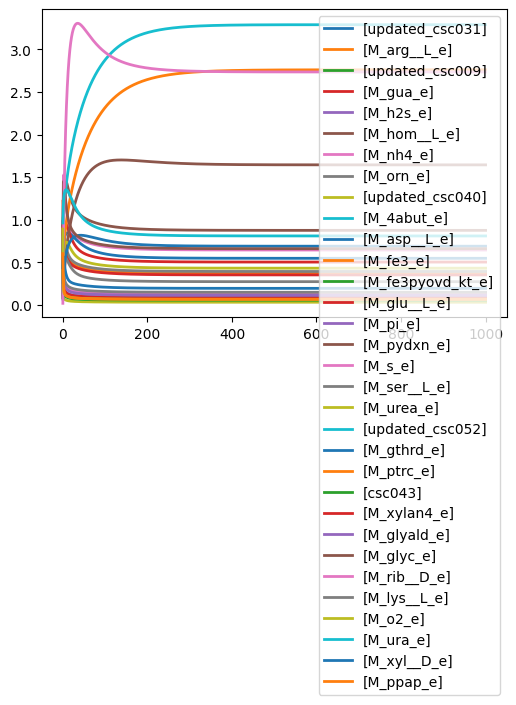

In [56]:
smbl_file = 'smetana_carbstor_consumer_resource.xml'
rr_model = te.loada(antimony_file)
rr_model.exportToSBML(smbl_file)

# simulate and plot
rr_model.simulate(0, 1000, 2000)
rr_model.plot()

In [58]:
import libsbml
corrected_smbl_file = 'smetana_carbstor_consumer_resource_corrected.xml'

d = libsbml.readSBMLFromFile(smbl_file)
m = d.getModel()
# for initial in m.getListOfInitialAssignments():
#     print(initial)

for species in m.getListOfSpecies():
    species.name = species.id
    species.initial_concentration = species.initial_amount
    species.has_only_substance_units = False

libsbml.writeSBMLToFile(d,corrected_smbl_file)

1

### load SBML into MIRA


In [59]:
from mira.sources.sbml import template_model_from_sbml_file



In [60]:
smetana_model = template_model_from_sbml_file(corrected_smbl_file)

smetana_model.initials


{'updated_csc031': Initial(concept=Concept(name='updated_csc031', display_name='updated_csc031', description=None, identifiers={}, context={}, units=None), expression=0.925596638292661),
 'M_arg__L_e': Initial(concept=Concept(name='M_arg__L_e', display_name='M_arg__L_e', description=None, identifiers={}, context={}, units=None), expression=0.791725038082665),
 'updated_csc009': Initial(concept=Concept(name='updated_csc009', display_name='updated_csc009', description=None, identifiers={}, context={}, units=None), expression=0.639921021327524),
 'M_gua_e': Initial(concept=Concept(name='M_gua_e', display_name='M_gua_e', description=None, identifiers={}, context={}, units=None), expression=0.568044561093932),
 'M_h2s_e': Initial(concept=Concept(name='M_h2s_e', display_name='M_h2s_e', description=None, identifiers={}, context={}, units=None), expression=0.715189366372419),
 'M_hom__L_e': Initial(concept=Concept(name='M_hom__L_e', display_name='M_hom__L_e', description=None, identifiers={}, 

In [70]:
# from mira.model import 

# for parameter in smetana_model.parameters:
#     print(parameter)
    
    

k_d0


AttributeError: 'str' object has no attribute 'distribution'

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'removeprefix',
 'removesuffix',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',


In [11]:
# initial conditions 


### load MIRA into pyCIEMSS (specify priors)
### simulate the model in pyCIEMSS (specify initial conditions)

see: https://github.com/ciemss/pyciemss/blob/main/docs/source/interfaces.ipynb


In [61]:
import os
import pyciemss
import torch
import pandas as pd
import numpy as np
from typing import Dict, List, Callable

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
    start_time_param_value_objective,
)

smoke_test = "CI" in os.environ



In [64]:


# load model
# load data

# 

# set parameters
start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_samples = 1

In [66]:
result1 = pyciemss.sample(smetana_model, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())



,timepoint_id,sample_id,timepoint_unknown,updated_csc031_state,M_arg__L_e_state,updated_csc009_state,M_gua_e_state,M_h2s_e_state,M_hom__L_e_state,M_nh4_e_state,...,csc043_state,M_xylan4_e_state,M_glyald_e_state,M_glyc_e_state,M_rib__D_e_state,M_lys__L_e_state,M_o2_e_state,M_ura_e_state,M_xyl__D_e_state,M_ppap_e_state
0,0,0,0.0,0.925597,0.791725,0.639921,0.568045,0.715189,0.383442,0.544883,...,0.461479,0.978618,0.870012,0.087129,0.020218,0.799159,0.891773,0.963663,0.437587,0.602763
1,1,0,10.0,0.208859,0.585933,0.101195,0.570333,0.142036,1.419496,1.061469,...,0.088996,0.136734,0.181837,1.078124,2.513031,0.233125,0.104449,1.348223,0.323899,0.103876
2,2,0,20.0,0.185105,0.498503,0.087151,0.478089,0.122162,1.228439,0.877837,...,0.075968,0.115701,0.153223,0.897349,3.129063,0.199605,0.089541,1.248869,0.264674,0.088086
3,3,0,30.0,0.174868,0.463359,0.080978,0.443826,0.113870,1.121201,0.810883,...,0.070624,0.107310,0.141811,0.828635,3.293252,0.185782,0.083070,1.142994,0.246415,0.081449
4,4,0,40.0,0.168312,0.443137,0.077489,0.424213,0.109014,1.062743,0.773747,...,0.067550,0.102541,0.135432,0.790449,3.297634,0.177791,0.079437,1.062352,0.236119,0.077776


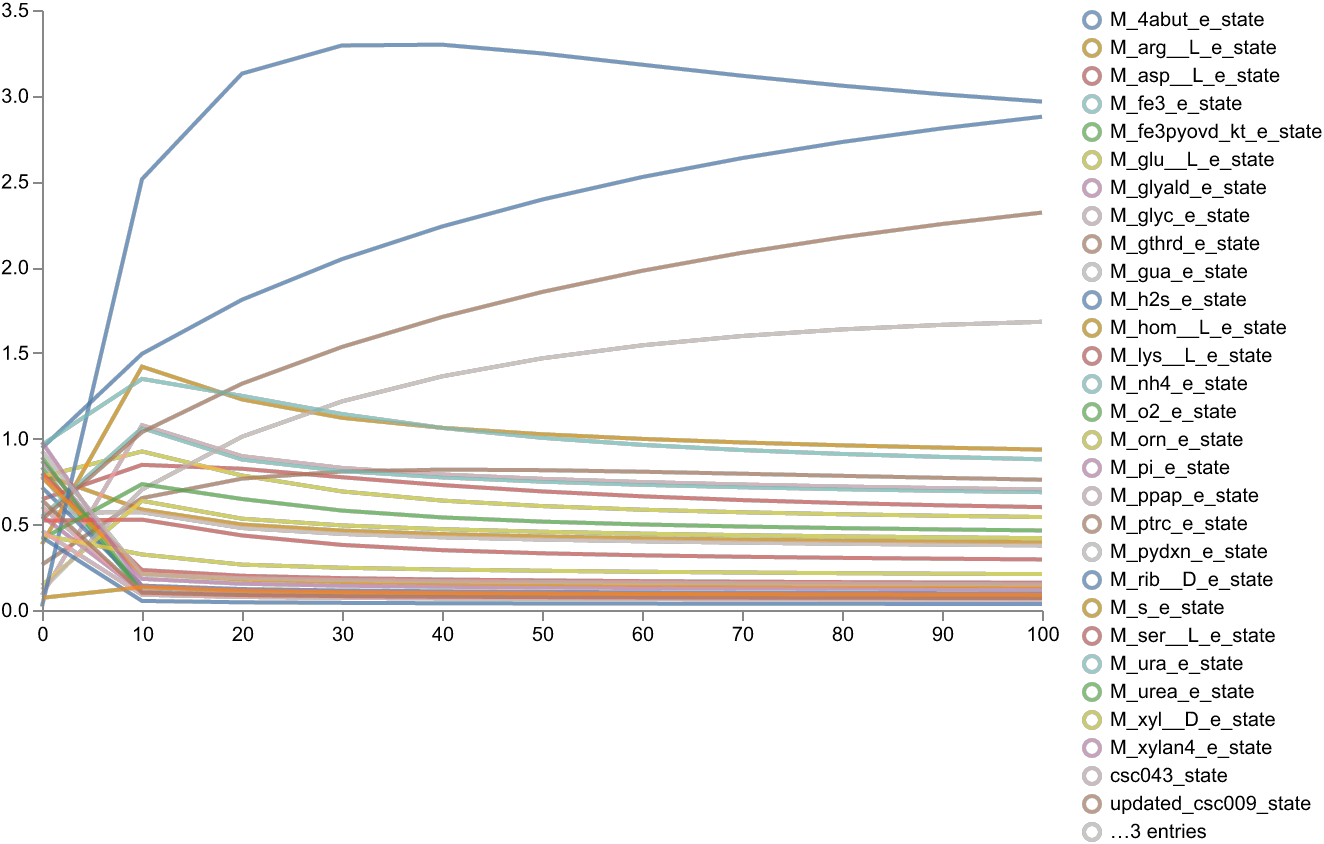

In [67]:
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)